# Merge Requests

Merge Requests represent the core unit of work, and have the closest representation to a [SAFe Story](https://www.scaledagileframework.com/story/).  

Each Merge Request must have a valid Jira ticket ID at the beginning of the title, and reference a source branch that starts with a valid jira ticket ID.

In [1]:
# include common code and config
# selected_pi = 16
%run PIQM_Bootstrap.ipynb

Current PI: {'pi': 'PI16', 'id': 16, 'start': '2022-09-14T00:00:00Z', 'started': '2022-09-14', 'finish': '2022-12-13T23:59:59Z'}
Last start: 2022-09-14T00:00:00Z


# Authors with the highest Merge Request activity


In [14]:
query = \
    """from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> filter(fn: (r) => r.author != "piersharding")
  |> drop(columns:["state", "jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> distinct(column: "mr_id")
  |> group(columns: ["authorname"])
  |> count()
  |> group()
  |> sort(columns: ["_value"], desc: true)
  |> top(n:10)""".format(current_pi)

query



'from(bucket: "gitlab_metrics")\n  |> range(start: 2022-09-14T00:00:00Z, stop: 2022-12-13T23:59:59Z)\n  |> filter(fn: (r) => r._measurement == "merge_requests")\n  |> filter(fn: (r) => r.state == "merged")\n  |> filter(fn: (r) => r.author != "piersharding")\n  |> drop(columns:["state", "jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])\n  |> distinct(column: "mr_id")\n  |> group(columns: ["authorname"])\n  |> count()\n  |> group()\n  |> sort(columns: ["_value"], desc: true)\n  |> top(n:10)'

In [15]:
query_api = client.query_api()
df_topN = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["state", "jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> distinct(column: "mr_id")
  |> group(columns: ["authorname"])
  |> count()
  |> group()
  |> sort(columns: ["_value"], desc: true)
  |> top(n:10)""".format(current_pi))
df_topN = df_topN[["authorname", "_value"]].rename(columns={"_value": "Merge Requests", "authorname": "Author"})
df_topN.style.hide_index()\
    .set_properties(subset=['Author'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('Top 10 Merge Requesters')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])




/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "gitlab_metrics")
  |> range(start: 2022-09-14T00:00:00Z, stop: 2022-12-13T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["state", "jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> distinct(column: "mr_id")
  |> group(columns: ["authorname"])
  |> count()
  |> group()
  |> sort(columns: ["_value"], desc: true)
  |> top(n:10) |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    w

# Merge Requests by PI over the PI timeframe

Plot of Merge Requests created and completed over the life of a PI.  The following plot compares the trend of when and how many successful Merge Requests are created.

In [16]:
first_mr_trace = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["mr_id", "state", "author", "authorname", "jira", "branch_jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> aggregateWindow(every: 1d, fn: count)
  |> cumulativeSum(columns: ["_value"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "_field",value: "{0[pi]} ({0[started]})")
  |> set(key: "_field2",value: "{0[id]}")
"""

template_mr_trace = """
time1{0[pi]} = uint(v: {0[start]})
time2{0[pi]} = uint(v: {0[current_start]})
dur{0[pi]} = duration(v: time2{0[pi]} - time1{0[pi]})

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["mr_id", "state", "author", "authorname", "jira", "branch_jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> aggregateWindow(every: 1d, fn: count)
  |> cumulativeSum(columns: ["_value"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "_field",value: "{0[pi]} ({0[started]})")
  |> set(key: "_field2",value: "{0[id]}")
  |> timeShift(duration: dur{0[pi]}, columns: ["_start", "_stop", "_time"])
"""

# output all the series in reverse order
pis = the_pis.copy()
current = pis.pop(-1)
pi_list = ([current] + pis[: (selected_pi - select_pis) : -1])[::-1]
query = [first_mr_trace.format(current)]
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pis[: (selected_pi - select_pis) : -1]:
    pi["current_start"] = last_start
#     print(pi)
    query.append(template_mr_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()
df_merge_requests_by_PI = query_api.query_data_frame(query)
df_merge_requests_by_PI = df_merge_requests_by_PI[["_time", "_value", "_field", "_field2"]]\
    .rename(columns={"_value": "Merge Requests", "_time": "Date", "_field": "PI", "_field2": "ID"})
df_merge_requests_by_PI['Days'] = df_merge_requests_by_PI\
    .apply(lambda row: (row.Date - df_merge_requests_by_PI.Date[0]).days, axis=1)
df_merge_requests_by_PI['ID'] = df_merge_requests_by_PI['ID'].astype(int)
df_merge_requests_by_PI.sort_values(by=['ID', 'Days'], ascending=[False, True], inplace=True)
df_merge_requests_by_PI



/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
PI16 = from(bucket: "gitlab_metrics")
  |> range(start: 2022-09-14T00:00:00Z, stop: 2022-12-13T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["mr_id", "state", "author", "authorname", "jira", "branch_jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> aggregateWindow(every: 1d, fn: count)
  |> cumulativeSum(columns: ["_value"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "_field",value: "PI16 (2022-09-14)")
  |> set(key: "_field2",value: "16")


time1PI15 = uint(v: 2022-06-15T00:00:00Z)
time2PI15 = uint(v: 2022-09-14T00:00

Date  Merge Requests                 PI  ID  Days
0   2022-09-15 00:00:00+00:00              17  PI16 (2022-09-14)  16     0
1   2022-09-16 00:00:00+00:00              28  PI16 (2022-09-14)  16     1
2   2022-09-17 00:00:00+00:00              35  PI16 (2022-09-14)  16     2
3   2022-09-18 00:00:00+00:00              35  PI16 (2022-09-14)  16     3
4   2022-09-19 00:00:00+00:00              35  PI16 (2022-09-14)  16     4
..                        ...             ...                ...  ..   ...
361 2022-12-11 00:00:00+00:00             838  PI12 (2021-09-16)  12    87
362 2022-12-12 00:00:00+00:00             845  PI12 (2021-09-16)  12    88
363 2022-12-13 00:00:00+00:00             851  PI12 (2021-09-16)  12    89
364 2022-12-14 00:00:00+00:00             860  PI12 (2021-09-16)  12    90
365 2022-12-14 23:59:59+00:00             866  PI12 (2021-09-16)  12    90

[461 rows x 5 columns]

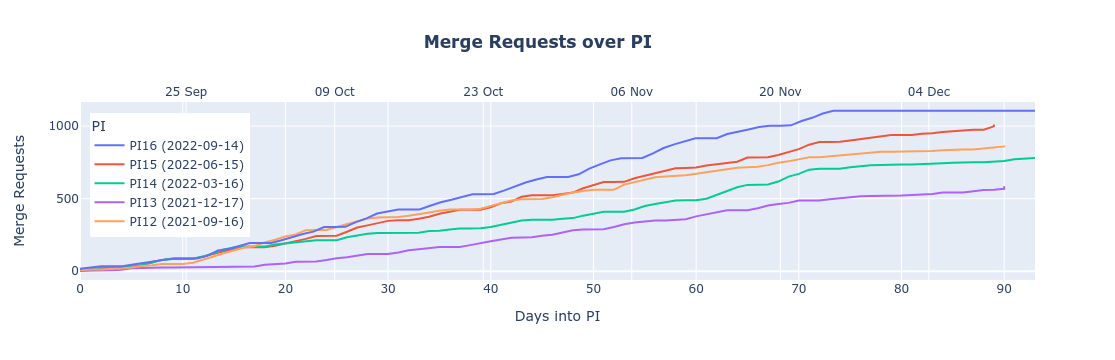

In [17]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

fig = px.line(df_merge_requests_by_PI,
              x="Days", y="Merge Requests", color='PI',
              labels={
                     "Days": "Days into PI",
                     "Merge Requests": "Merge Requests",
                     "PI": "PI"
                 },
              title='<b>Merge Requests over PI</b>')

# add 2nd axis to last PI which gives the hover
fig.data[0].update(xaxis='x2', x=df_merge_requests_by_PI.Date)
fig.update_layout(xaxis2= {
                           'anchor': 'y',
                           'overlaying': 'x',
                           'side': 'top',
                           'tickformat': "%d %b",
                           'showspikes': True,
                           'spikemode': 'across+toaxis',
                           'spikesnap': 'cursor',
                           'spikedash': 'solid',
                           'showline': True,
                           'showgrid': True,
                           
                        },
                  yaxis_domain=[0, 0.99]);
# reposition the title and legend, and set the hover mode
fig.update_layout(
    title={
        'y':0.9,
        'x':0.38,
        'xanchor': 'left',
        'yanchor': 'top'},
    legend={
        'yanchor': "top",
        'y': 0.93,
        'xanchor': "left",
        'x': 0.01,
        'traceorder':'normal'
    },
    hovermode  = 'x',
    hoverlabel_align = 'left',
)
fig.show()


In [18]:
template_mrs_without_jira = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> filter(fn: (r) => r.jira == "0")
  |> drop(columns:["mr_id", "state", "author", "authorname", "jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> aggregateWindow(every: 1d, fn: count)
  |> cumulativeSum(columns: ["_value"])
  |> sort(columns: ["dateTime"], desc: false)
  |> last()
  |> set(key: "_field",value: "{0[pi]}")
"""

query = []
for pi in pi_list:
    pi["current_start"] = last_start
    query.append(template_mrs_without_jira.format(pi))
tables = ", ".join([pi["pi"] for pi in pi_list])
query.append(
    """
union(tables: [{}])
  |> yield(name: "lines")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()
df_mr_without_jira_by_PI = query_api.query_data_frame(query)
df_mr_without_jira_by_PI = df_mr_without_jira_by_PI[["_value", "_field"]]\
    .rename(columns={"_value": "Merge Requests Without Jira", "_field": "PI"})
df_mr_without_jira_by_PI.style.hide_index()


/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
PI12 = from(bucket: "gitlab_metrics")
  |> range(start: 2021-09-16T00:00:00Z, stop: 2021-12-16T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> filter(fn: (r) => r.jira == "0")
  |> drop(columns:["mr_id", "state", "author", "authorname", "jira", "project", "project_id", "merged_by", "ref", "stale", "_measurement", "_field"])
  |> aggregateWindow(every: 1d, fn: count)
  |> cumulativeSum(columns: ["_value"])
  |> sort(columns: ["dateTime"], desc: false)
  |> last()
  |> set(key: "_field",value: "PI12")


PI13 = from(bucket: "gitlab_metrics")
  |> range(start: 2021-12-17T00:00:00Z, stop: 2022-03-1

In [19]:

first_mr_trace = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

template_mr_trace = """
time1{0[pi]} = uint(v: {0[start]})
time2{0[pi]} = uint(v: {0[current_start]})
dur{0[pi]} = duration(v: time2{0[pi]} - time1{0[pi]})

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
  |> timeShift(duration: dur{0[pi]}, columns: ["_start", "_stop", "_time"])
"""

# output all the series in reverse order
pis = the_pis.copy()
current = pis.pop(-1)
pi_list = ([current] + pis[: (selected_pi - select_pis) : -1])[::-1]
query = [first_mr_trace.format(current)]
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pis[: (selected_pi - select_pis) : -1]:
    pi["current_start"] = last_start
    query.append(template_mr_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

mrs = query_api.query_data_frame(query)
# mrs = mrs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
mrs['ID'] = mrs['ID'].astype(int)
mrs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
mrs[mrs['ID'] == 10]

/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
PI16 = from(bucket: "gitlab_metrics")
  |> range(start: 2022-09-14T00:00:00Z, stop: 2022-12-13T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> filter(fn: (r) => r.state == "merged")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "16")
  |> set(key: "PI",value: "PI16 (2022-09-14)")


time1PI15 = uint(v: 2022-06-15T00:00:00Z)
time2PI15 = uint(v: 2022-09-14T00:00:00Z)
durPI15 = duration(v: time2PI15 - time1PI15)

PI15 = from(bucket: "gitlab_metrics")
  |> range(start: 2022-06-15T00:00:00Z, stop: 2022-09-13T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "merge_reque

Empty DataFrame
Columns: [result, table, _start, _stop, _time, _value, author, authorname, branch_jira, jira, merged_by, mr_id, project, project_id, ref, stale, state, ID, PI]
Index: []

In [20]:
mrs_jira = mrs[mrs.stale=='0'][['ID', 'PI','jira','mr_id']].groupby(['ID', 'PI','jira']).agg(['count', 'size', 'nunique']).reset_index()
# mrs_jira.loc[mrs_jira.jira == '0', 'jira'] = 'no'
# mrs_jira.loc[mrs_jira.jira == '1', 'jira'] = 'yes'
mrs_jira.sort_values(by=['ID', 'jira'], ascending=[True, False], inplace=True)
mrs_jira[mrs_jira.jira == '0']
# mrs_jira.loc[mrs_jira.jira == '0', 'text'] = (mrs_jira[mrs_jira.jira == '1'].mr_id / (mrs_jira[mrs_jira.jira == '1'].mr_id + mrs_jira[mrs_jira.jira == '0'].mr_id))
# (mrs_jira[mrs_jira.jira == '1'].mr_id.reset_index() + 
#       mrs_jira[mrs_jira.jira == '0'].mr_id.reset_index())

no_jira = mrs_jira[mrs_jira.jira == '0'].reset_index()
no_jira['percent'] = (mrs_jira[mrs_jira.jira == '1'].reset_index().mr_id['count'] / (mrs_jira[mrs_jira.jira == '1'].reset_index().mr_id['count'] + mrs_jira[mrs_jira.jira == '0'].reset_index().mr_id['count']))
(mrs_jira[mrs_jira.jira == '1'].reset_index().mr_id['count'] + 
      mrs_jira[mrs_jira.jira == '0'].reset_index().mr_id['count'])

no_jira['total'] = (mrs_jira[mrs_jira.jira == '1'].reset_index().mr_id['count'] + 
      mrs_jira[mrs_jira.jira == '0'].reset_index().mr_id['count'])

no_jira['percent'] = (mrs_jira[mrs_jira.jira == '1'].reset_index().mr_id['count'] / 
     (mrs_jira[mrs_jira.jira == '1'].reset_index().mr_id['count'] + 
      mrs_jira[mrs_jira.jira == '0'].reset_index().mr_id['count'])) * 100
mrs_jira

ID                 PI jira mr_id              
                              count  size nunique
1  12  PI12 (2021-09-16)    1   816   816     816
0  12  PI12 (2021-09-16)    0    50    50      50
3  13  PI13 (2021-12-17)    1   546   546     546
2  13  PI13 (2021-12-17)    0    40    40      40
5  14  PI14 (2022-03-16)    1   750   750     750
4  14  PI14 (2022-03-16)    0    30    30      30
7  15  PI15 (2022-06-15)    1   946   946     946
6  15  PI15 (2022-06-15)    0    65    65      65
9  16  PI16 (2022-09-14)    1  1063  1063    1063
8  16  PI16 (2022-09-14)    0    43    43      43

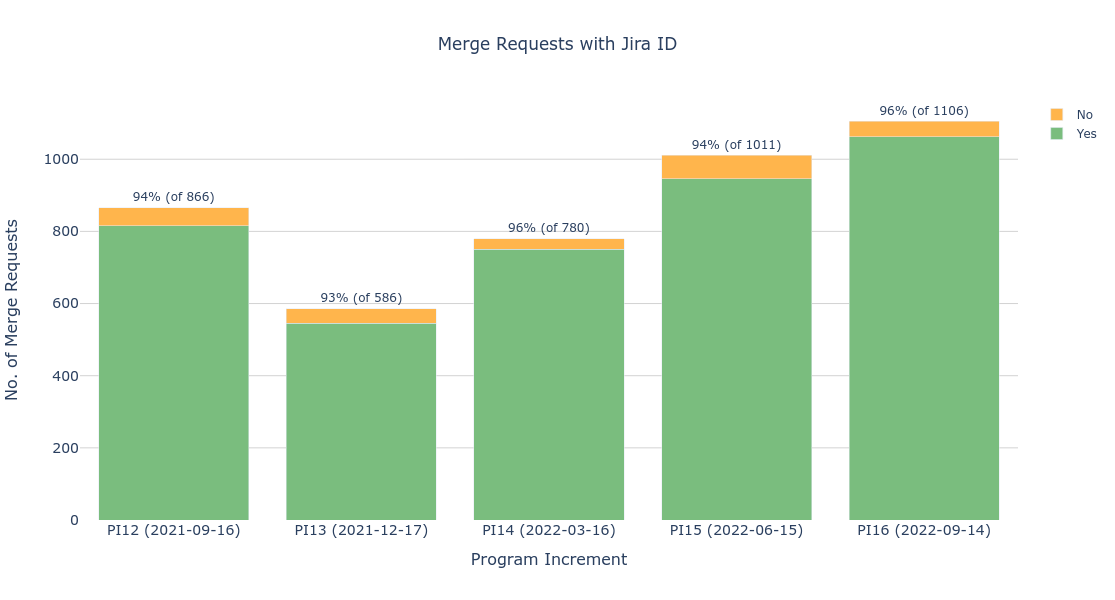

In [21]:
import plotly.graph_objects as go

stack_labels = ['{:.0f}% (of {:.0f})'.format(x, y) for x, y in zip(no_jira['percent'], no_jira['total'])]
fig = go.Figure(go.Bar(x=mrs_jira.PI.unique(), y=mrs_jira[mrs_jira.jira == '1'].mr_id['count'], name='Yes',
    marker_color='#7ABD7E'))
fig.add_trace(go.Bar(x=mrs_jira.PI.unique(), y=mrs_jira[mrs_jira.jira == '0'].mr_id['count'], name='No',
    marker_color='#FFB54C', text=stack_labels))
fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_traces(text=mrs_jira.PI.unique(), textposition='outside')
fig.update_traces( textposition='outside')
fig.update_layout(barmode='stack', yaxis=dict(
        title='No. of Merge Requests',
        titlefont_size=16,
        tickfont_size=14,
    ), xaxis=dict(
        title='Program Increment',
        titlefont_size=16,
        tickfont_size=14,
    ), height=600, title='Merge Requests with Jira ID', title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()
